# Lab - Chapter_7

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from patsy import dmatrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv(r'./data/Wage.csv')
print(data.shape)
data.head()

(3000, 13)


,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
# the first col dones't seem to be that relevant
data = data.iloc[:,1:]

# one hot encodung for qual variables
qual_variables = [col for col in data.columns if data[col].dtype == 'O']
print('Qualitative variables are - ',qual_variables)

# extracting the string 
for col in qual_variables:
    data[col] = data[col].map(lambda x:x[2:])
                              
data.head()                              

Qualitative variables are -  ['sex', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']


,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,Male,Never Married,White,< HS Grad,Middle Atlantic,Industrial,<=Good,No,4.318063,75.043154
1,2004,24,Male,Never Married,White,College Grad,Middle Atlantic,Information,>=Very Good,No,4.255273,70.476020
2,2003,45,Male,Married,White,Some College,Middle Atlantic,Industrial,<=Good,Yes,4.875061,130.982177
3,2003,43,Male,Married,Asian,College Grad,Middle Atlantic,Information,>=Very Good,Yes,5.041393,154.685293
4,2005,50,Male,Divorced,White,HS Grad,Middle Atlantic,Information,<=Good,Yes,4.318063,75.043154


In [4]:
# To convert it to dummy variables i will use a class created by me
###### --------- This is a class created by me for ne hot encoding, it makes the task easier(check link below) ------#######
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class Myencoder(BaseEstimator, TransformerMixin):
   
    def __init__(self,drop = 'first',sparse=False):
        self.encoder = OneHotEncoder(drop = drop,sparse = sparse)
        self.features_to_encode = []
        self.columns = []
    
    def fit(self,X_train,features_to_encode):
        
        data = X_train.copy()
        self.features_to_encode = features_to_encode
        data_to_encode = data[self.features_to_encode]
        self.columns = pd.get_dummies(data_to_encode,drop_first = True).columns
        self.encoder.fit(data_to_encode)
        return self.encoder
    
    def transform(self,X_test):
        
        data = X_test.copy()
        data.reset_index(drop = True,inplace =True)
        data_to_encode = data[self.features_to_encode]
        data_left = data.drop(self.features_to_encode,axis = 1)
        
        data_encoded = pd.DataFrame(self.encoder.transform(data_to_encode),columns = self.columns)
        
        return pd.concat([data_left,data_encoded],axis = 1)

https://github.com/hardikkamboj/Code

In [5]:
my_encoder = Myencoder()
my_encoder.fit(data,features_to_encode = qual_variables)
data = my_encoder.transform(data)
data.head()
## See how easitly we get the dataframe back, not only this we can use this also to transform any test data
# but we are not having any test data at the moment, but i don't know why fit_transform doesn't work, i will check into that 

,year,age,logwage,wage,maritl_ Married,maritl_ Never Married,maritl_ Separated,maritl_ Widowed,race_ Black,race_ Other,race_ White,education_ Advanced Degree,education_ College Grad,education_ HS Grad,education_ Some College,jobclass_ Information,health_ >=Very Good,health_ins_ Yes
0,2006,18,4.318063,75.043154,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,24,4.255273,70.476020,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2003,45,4.875061,130.982177,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2003,43,5.041393,154.685293,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4,2005,50,4.318063,75.043154,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Polynomial regression and step functions

Fit a polynomial function of the form - 
Y = beta_0 + beta_1*X + beta_2*X^2 + beta_3*X^4 + beta_4*X^4

In [6]:
poly = PolynomialFeatures(4)
X = poly.fit_transform(data['age'].to_frame())
y = data['wage']
# X.shape

model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sun, 28 Mar 2021   Prob (F-statistic):           2.77e-57
Time:                        17:37:44   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

In [7]:
# So, what we want here is not only the final line, but also the standart error related to the line
# TO find that we need to calcualte the predictions for some values of age
test_ages = np.linspace(data['age'].min(),data['age'].max(),100)

X_test = poly.transform(test_ages.reshape(-1,1))
pred = model.predict(X_test)

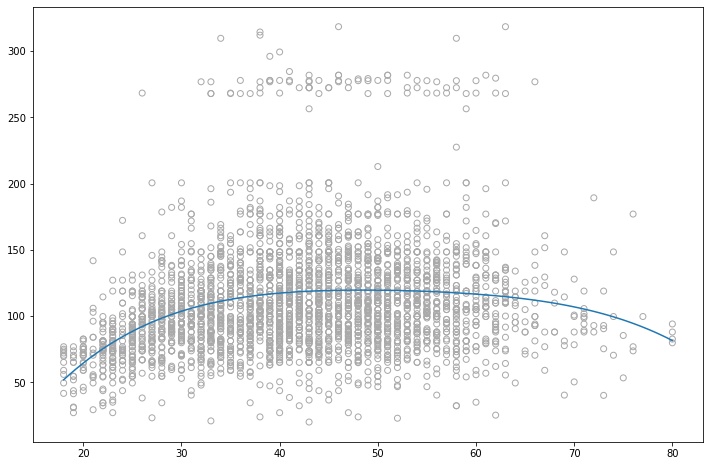

In [8]:
pred = model.predict(X_test)
plt.figure(figsize = (12,8))
plt.scatter(data['age'],data['wage'],facecolors='none', edgecolors='darkgray')
plt.plot(test_ages,pred)


#### Calculating and plotting confidence intervals 
#### i have used bootstrap for calculating confidence intervals, for this i have a self constructed module which you can find 
#### in the link belowe, this enables us to calculate the confidenc intervals in just a single line of code

https://github.com/hardikkamboj/Code/tree/master/Confidence_intervals_using_boorstraping

#### to run it, get the bootstrap.py file and paste it at the same folder wherer your current notebook is running. 
#### restart the kernel if it is not able to import the module
#### kindly consider giving a credit if you use it. :)

In [12]:
from bootstrap import Bootstrap_ci
bootstrap = Bootstrap_ci()

In [13]:
li,ui = bootstrap.boot(pd.DataFrame(X),y,1000,X_test,LinearRegression())

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 441.53it/s]


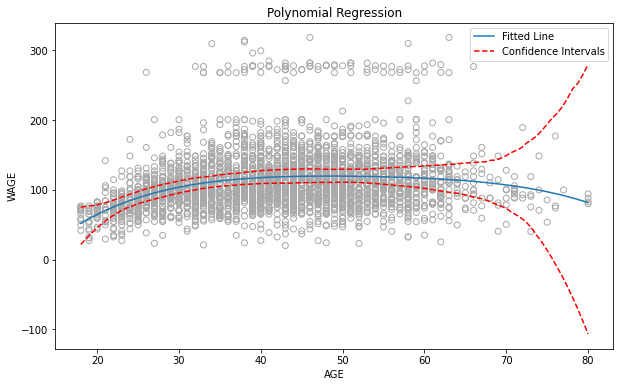

In [14]:
pred = model.predict(X_test)
plt.figure(figsize = (10,6))
plt.scatter(data['age'],data['wage'],facecolors='none', edgecolors='darkgray')
plt.plot(test_ages,pred,label = 'Fitted Line')
plt.plot(test_ages,ui,linestyle = 'dashed',color = 'r',label = 'Confidence Intervals')
plt.plot(test_ages,li,linestyle = 'dashed',color = 'r')
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.title('Polynomial Regression')
plt.legend()

## Selecting the best degree with ANOVA

Null hypothesis is that a model M1 is sufficient to explain the data, and alternative hypothese is that a more complex model is needed. Also, for this to happen, M1 and M2 must be nested functions that is features in M1 must be a subset to features in M2.<br>
https://www.statsmodels.org/stable/anova.html

In [15]:
poly = PolynomialFeatures(5)
X = poly.fit_transform(data['age'].to_frame())
y = data['wage']
X_df = pd.DataFrame(X)
X_df.columns = ['Constant']+['X_' + str(i) for i in range(1,6)]
X_df.head()

,Constant,X_1,X_2,X_3,X_4,X_5
0,1.0,18.0,324.0,5832.0,104976.0,1889568.0
1,1.0,24.0,576.0,13824.0,331776.0,7962624.0
2,1.0,45.0,2025.0,91125.0,4100625.0,184528125.0
3,1.0,43.0,1849.0,79507.0,3418801.0,147008443.0
4,1.0,50.0,2500.0,125000.0,6250000.0,312500000.0


In [16]:
fit_1 = sm.OLS(y,X_df.iloc[:,:2]).fit() #degree 1
fit_2 = sm.OLS(y,X_df.iloc[:,:3]).fit() # degree 2
fit_3 = sm.OLS(y,X_df.iloc[:,:4]).fit()  #degree 3
fit_4 = sm.OLS(y,X_df.iloc[:,:5]).fit()  # degree 4
fit_5 = sm.OLS(y,X_df.iloc[:,:6]).fit() # degree 5

table = sm.stats.anova_lm(fit_1,fit_2,fit_3,fit_4,fit_5)
print(table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


In [17]:
# We can see from the table that p value for the second row is very small, of the order e^-32. 
# Through this we conclue that linear model is not sufficient to explain the data. 
# Remember this was the alternative hypotheses. Since p value is very significant, we reject null hypothese, according to which
# linear model is enough to explain the data. 

# the next couple of p values are small, not that small, but enough to reject the null hypotheses. 
# But, if we see the p value of last row, which is comparing model with degree 4 and degre 5, we can see that the p value if 
# approx 0.37. and hence its not that small. Through this we can conclude that model with degree 4 is enough to explain the 
# data and we don't need a higher degree than that. 

# Hence we conlude that model with degree 3 or 4 are reasonable to fit the data, but lower degree model and higher degre models
# are not justified.

In [18]:
# lets look at the model with degree 5
print(fit_5.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.71
Date:                Sun, 28 Mar 2021   Prob (F-statistic):           1.67e-56
Time:                        17:40:28   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -49.7046    161.435     -0.308      0.7

In [19]:
# We can see that the p value for X_5 is equal for the p value that we got in Annova, also the square of t value for X_5. 
# give the value of F statistic that was there in ANNOVA. but thse are not true for X_1,X_2, and other predictors.
# Althoug if we look for p values for X_2, in fit_2, we will get the results as expected. Same is true for X_1 in fit 1, 
# X_3 in fit_3, etc

### Annova can also be used when we have other terms in the model

In [20]:
# to select education we select the cols containing dummy variables of education - data.iloc[:,11:15]
fit_1 = sm.OLS(y,pd.concat([X_df.iloc[:,:2],data.iloc[:,11:15]],axis = 1)).fit()
fit_2 = sm.OLS(y,pd.concat([X_df.iloc[:,:3],data.iloc[:,11:15]],axis = 1)).fit()
fit_3 = sm.OLS(y,pd.concat([X_df.iloc[:,:4],data.iloc[:,11:15]],axis = 1)).fit()

table = sm.stats.anova_lm(fit_1,fit_2,fit_3)
print(table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2994.0  3.867992e+06      0.0            NaN         NaN           NaN
1    2993.0  3.725395e+06      1.0  142597.097010  114.696898  2.728001e-26
2    2992.0  3.719809e+06      1.0    5586.660322    4.493588  3.410431e-02


# Predicting whether an individal earns more than 250,000
## Logistic Polynomail regression

In [21]:
data['wage_binary'] = np.where(data['wage']>250,1,0)
print(data['wage_binary'].value_counts())
y = data['wage_binary']
poly = PolynomialFeatures(4)
X = poly.fit_transform(data['age'].to_frame())
X_df = pd.DataFrame(X)
X_df.columns = ['Constant']+['X_' + str(i) for i in range(1,5)]
X_df.head()


0    2921
1      79
Name: wage_binary, dtype: int64


,Constant,X_1,X_2,X_3,X_4
0,1.0,18.0,324.0,5832.0,104976.0
1,1.0,24.0,576.0,13824.0,331776.0
2,1.0,45.0,2025.0,91125.0,4100625.0
3,1.0,43.0,1849.0,79507.0,3418801.0
4,1.0,50.0,2500.0,125000.0,6250000.0


In [22]:
model = sm.Logit(y,X_df).fit()

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


Text(0, 0.5, 'Prob wage > 250k, given age')

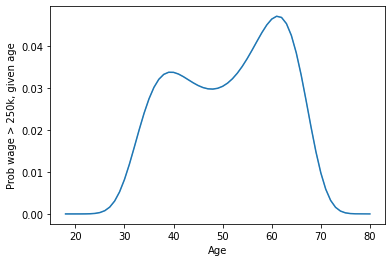

In [25]:
pred = model.predict(X_df)
sns.lineplot(x=data['age'], y=pred)
plt.xlabel('Age')
plt.ylabel('Prob wage > 250k, given age')
# we can see how the prob that the wage will be greater than 250k, vary with age.
# It increases with age at the beginning, reaches a global maximum at age around 35, decreases reaches a min, increases 
# and hits the global maximum at age around 62, after it, it decreases again.

## But how to draw the confidence bands??

In [26]:
# we are going to use the boot_sm method in the bootstrap class, but will change it a bit

https://github.com/hardikkamboj/Code/tree/master/Confidence_intervals_using_boorstraping

In [27]:
# lets select some ages for testing
test_ages = np.linspace(5,80,100)
# getting the polynomial data by the same transformer (poly) that we used for training data
X_test = poly.fit_transform(test_ages.reshape(-1,1))
test_preds = model.predict(X_test)

In [28]:
#  It worked for me when i passed the size of boostrap samples = size(X_data), earlier it was hardcoded to 200.
def boot(X_data,y_data,R,test_data):
    predictions = []
    for i in range(R):
        predictions.append(alpha(X_data,y_data,get_indices(X_data,len(X_data)),test_data))

    return np.percentile(predictions,2.5,axis = 0),np.percentile(predictions,97.5,axis = 0)

def alpha(X_data,y_data,index,test_data):
    X = X_data.loc[index]
    y = y_data.loc[index]

    model = sm.Logit(y,X).fit(disp = 0) #disp = 0, to not print anything

    return model.predict(pd.DataFrame(test_data))


def get_indices(data,num_samples):
    return  np.random.choice(data.index, num_samples, replace=True)

In [29]:
li,ui = boot(X_df,y,1000,X_test)

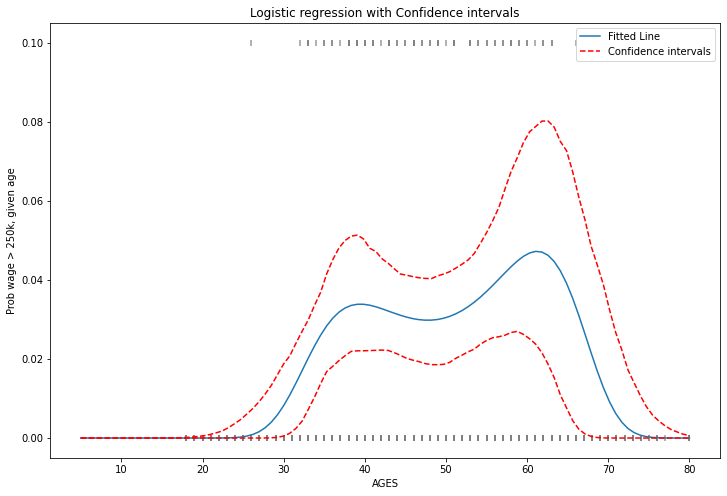

In [30]:
plt.figure(figsize = (12,8))
plt.plot(test_ages,test_preds,label = 'Fitted Line')
plt.plot(test_ages,li,linestyle = 'dashed',color = 'r',label = 'Confidence intervals')
plt.plot(test_ages,ui,linestyle = 'dashed',color = 'r')
plt.scatter(data['age'],data['wage_binary'] / 10,s = 30,c = 'grey',marker = '|',alpha = 0.8)
# data['wage_binary'] / 10, is done so that the upper portion of rugplot will be at 0.10
# otherwise, the scale of y axis would have changes, s refer to marker size, c to color, alpha to whether its transparent 
# or opaque
plt.xlabel('AGES')
plt.ylabel('Prob wage > 250k, given age')
plt.title('Logistic regression with Confidence intervals')
plt.legend()

for the portion on the botton of the graph, i have used scatterplot
https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.scatter.html

# Step Functions

In [31]:
X_cut = pd.cut(data['age'],4)

In [32]:
X_cut = pd.get_dummies(X_cut)
X_cut.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1,0,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [33]:
y = data['wage']
model = sm.OLS(y,X_cut).fit()

pred_step = model.predict(X_cut)

Text(0.5, 1.0, 'Step functions with steps - 4')

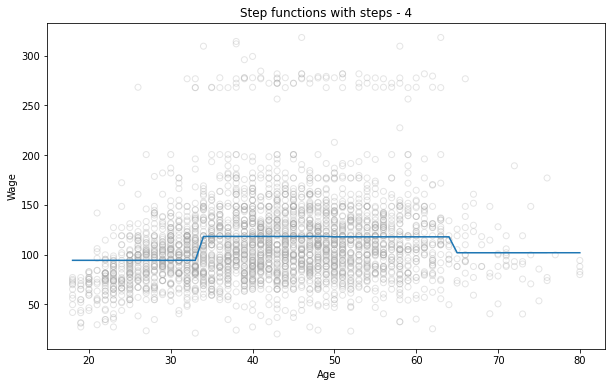

In [35]:
plt.figure(figsize = (10,6))
plt.scatter(data['age'],data['wage'],alpha = 0.3,facecolor = 'none', edgecolors='darkgray')
sns.lineplot(x=data['age'], y=pred_step)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Step functions with steps - 4')

In [36]:
# its not looking that great, in the middle its almost flat. Lets increase the binsize

Text(0.5, 1.0, 'Step function with steps - 8')

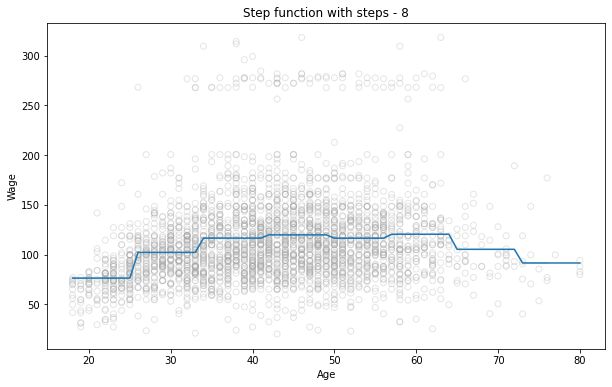

In [38]:
# i have doubled the steps, it reallly looks like steps..
X_cut = pd.cut(data['age'],8)
X_cut = pd.get_dummies(X_cut)

y = data['wage']
model = sm.OLS(y,X_cut).fit()

pred_step = model.predict(X_cut)

plt.figure(figsize = (10,6))
plt.scatter(data['age'],data['wage'],alpha = 0.3,facecolor = 'none', edgecolors='darkgray')
sns.lineplot(x=data['age'], y=pred_step)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Step function with steps - 8')

# 7.8.2 SPLINES

checkout this if you have some time - https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/

In [39]:
# For generating splines, we first need to have an appropriate matrix for basis functions 
# in R it is done by bs() functions, in python we will do it by using bs() in dmatrix function from patsy library 
# so, briefly -- Data -> convert into matrix using dmatrix -> fit this with OLS, or GLM (generalised linear model)

patcy.dmatrix - https://patsy.readthedocs.io/en/latest/API-reference.html

In [40]:
# fit a spline with knots at 25, 40 and 60
transformed_x = dmatrix("bs(age , knots = (25,40,60), degree = 3, include_intercept = False)",data = {'age':data['age']},
                                                                                                  return_type = 'dataframe')

# design = dmatrix("bs(age, knots=(25,40,60), degree=3, include_intercept=False)", data={"age":Wages.age}, 
#                  return_type="dataframe")

In [41]:
transformed_x.head() #this looks complex

,Intercept,"bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0


In [42]:
# fit a GLM model to the transformded data
fit1 = sm.GLM(data['wage'], transformed_x).fit()

# lets get some predictions and try to plot this cureve
test_dmatrix1 = dmatrix("bs(test_ages , knots = (25,40,60), degree = 3, include_intercept = False)",
                                                                                 data = {'test_ages':test_ages},
                                                                                                  return_type = 'dataframe')
pred1 = fit1.predict(test_dmatrix1)

Text(0.5, 1.0, 'Cubic Spline')

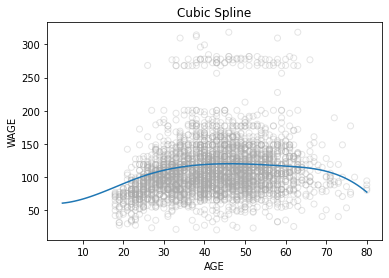

In [43]:
plt.scatter(data['age'],data['wage'],alpha = 0.3,facecolor = 'none', edgecolors='darkgray')
plt.plot(test_ages,pred1)
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.title('Cubic Spline')

In [47]:
#Confidence intervals
def boot(X_data,y_data,R,test_data):
  predictions = []
  for i in range(R):
    predictions.append(alpha(X_data,y_data,get_indices(X_data,len(X_data)),test_data))

  return np.percentile(predictions,2.5,axis = 0),np.percentile(predictions,97.5,axis = 0)

def alpha(X_data,y_data,index,test_data):
  X = X_data.loc[index]
  y = y_data.loc[index]

  model = sm.GLM(y,X).fit(disp = 0) #disp = 0, to not print anything

  return model.predict(pd.DataFrame(test_data))


def get_indices(data,num_samples):
  return  np.random.choice(data.index, num_samples, replace=True)

In [48]:
li,ui = boot(transformed_x,data['wage'],1000,test_dmatrix1)

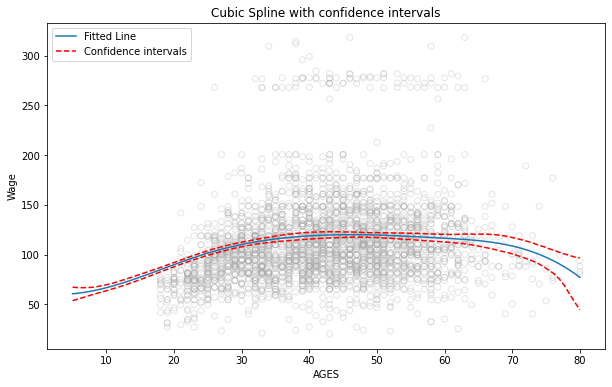

In [49]:
plt.figure(figsize = (10,6))
plt.scatter(data['age'],data['wage'],alpha = 0.3,facecolor = 'none', edgecolors='darkgray')
plt.plot(test_ages,pred1,label = 'Fitted Line')
plt.plot(test_ages,li,linestyle = 'dashed',color = 'r',label = 'Confidence intervals')
plt.plot(test_ages,ui,linestyle = 'dashed',color = 'r')
plt.xlabel('AGES')
plt.ylabel('Wage')
plt.title('Cubic Spline with confidence intervals')
plt.legend()

In [50]:
# in the above example, we hardcoded the values of the knots - [25,40,60], however, we can also use df (degress of freedom),
# and this will choose equally spaced knots

## Natural Splines

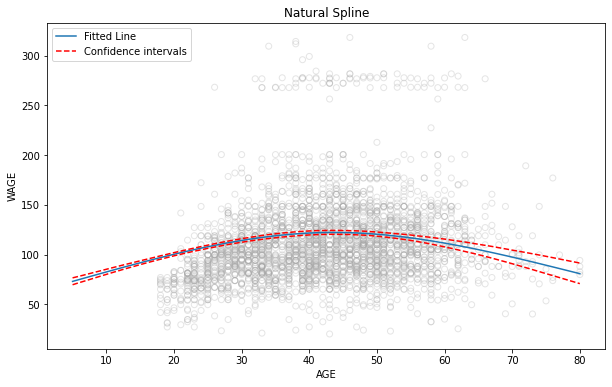

In [51]:
# fit a spline with knots at 25, 40 and 60
transformed_x2 = dmatrix("cr(age,df = 3)", {"age": data['age']}, return_type='dataframe')

# fit a GLM model to the transformded data
fit2 = sm.GLM(data['wage'], transformed_x2).fit()

# lets get some predictions and try to plot this cureve
test_dmatrix2 = dmatrix("cr(test_ages,df = 3)", {"test_ages": test_ages}, return_type='dataframe')
pred2 = fit2.predict(test_dmatrix2)

#confidence intervals 
li,ui = boot(transformed_x2,data['wage'],1000,test_dmatrix2)

plt.figure(figsize = (10,6))
plt.scatter(data['age'],data['wage'],alpha = 0.3,facecolor = 'none', edgecolors='darkgray')
plt.plot(test_ages,pred2,label = 'Fitted Line')
plt.plot(test_ages,li,linestyle = 'dashed',color = 'r',label = 'Confidence intervals')
plt.plot(test_ages,ui,linestyle = 'dashed',color = 'r')
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.title('Natural Spline')
plt.legend()

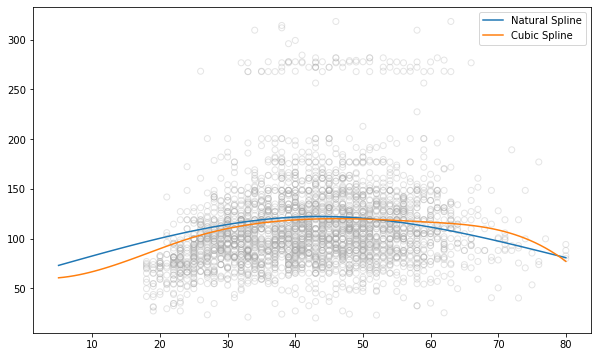

In [52]:
# comparing both of them
plt.figure(figsize = (10,6))
plt.scatter(data['age'],data['wage'],alpha = 0.3,facecolor = 'none', edgecolors='darkgray')
plt.plot(test_ages,pred2,label = 'Natural Spline')
plt.plot(test_ages,pred1,label = 'Cubic Spline')
plt.legend()

In [53]:
# even from the confidence intervals, we can see how well it is performing,better than cubic spline
# now see as we move to polynomial to natural spline, the confidence interval is getting more narrow. 
# the narrow the confidence interval - better the model

# GAM's is available in different notebook in the repository

# Happy learning, do show your support if you like it. Give a Star :)